In [2]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [3]:
# Importing package for KMeans algorithm
from sklearn.cluster import KMeans

# Feature extraction using SIFT
# takes list of images as input
# returns array of sift descriptors as ddescribed in task 
def extract_features(data):
    
    features = np.zeros((0, 128))
    
    for i in range(len(data)):
        im = data[i]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        features = np.vstack((features, des))
                
    return features

# Running k_means and getting clusters
# take features from function above
# return vocabulary
def cluster_features(features, k=200):
    
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(features)
    return kmeans.cluster_centers_

# print(f"FEATURES:\n{features}")
# print(f"CLUSTERS:\n{clusters}")

In [4]:
#input clusters and data that is just and array of images
def bag_of_words(clusters, data, idf=True):
    # gets bag of words for each image in data
    all_bags = []
    for i in range(len(data)):
        im = data[i] # [0]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        #print(des)
        
        # get histogram of clusters / bag of words for one image
        bag_of_words = np.zeros(len(clusters))
        for d in des:
            distances = np.linalg.norm(clusters - d, axis=1)
            bag_of_words[np.argmin(distances)] += 1
        all_bags.append(bag_of_words)
    
    if idf:
        bags_array = np.array(all_bags)
        bags_array[bags_array != 0] = 1
        
        idf_w = np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))
        #print(np.min(np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))))
        #print(all_bags[0])
        all_bags = [bag * idf_w for bag in all_bags]        
        #print(all_bags[0])
            
        
    return all_bags

#bags = bag_of_words(clusters, train)

In [15]:
import pandas as pd
category_tables = []

def make_table():
    #file name, true category, training/test set, word histogram
    table = {"file_name" : [],
             "category" : [],
             "test-train" : [],
             "im" : [],
             "hist": []}
    
    #get categories
    dir_list = []
    for dirs in os.listdir("caltech-101/101_ObjectCategories/"):
        dir_list.append(os.path.join("caltech-101/101_ObjectCategories", dirs))
        
    random.Random(6).shuffle(dir_list)      
    random_categories = dir_list[:1] 

    
    #get images from each category
    for category in random_categories:
        # get files in each category
        for file in os.listdir(category):
            table["file_name"] = table.get("file_name", []) + [file]
            table["category"] = table.get("category", []) + [category.split("/")[-1]]
            im = cv2.imread(os.path.join(category, file))
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            table["im"] = table.get("im", []) + [gray]
            
    # shuffle data and split into train and test
    test_train = []
    
    if len(table.get("category")) % 2 == 0:
        half = int(len(table.get("category")) / 2)
        #test_train = ["test"] * half + ["train"] * half
        test_train = ["test", "train"] * half

    else:
        half = int(len(table.get("category")) / 2)
        test_train = ["test", "train"] * half + ["train"]

    #random.Random(5).shuffle(test_train)
    
    table["test-train"] = test_train
        
    return table
    
table = make_table()

train = []
test = []

for i in range(len(table["test-train"])):
    test_train = table["test-train"]
    im = table["im"]
    
    if test_train[i] == "test":
        test.append(im[i])
    elif test_train[i] == "train":
        train.append(im[i])
        
# Gather descriptors in training image data set
features = extract_features(train)
# get vocabulary
clusters = cluster_features(features, k=300)

#create bags of words for each image
table["hist"] = bag_of_words(clusters, table["im"], idf=True)

In [5]:
'''
    Gennemløb alle kategorier
    For hver kategori
        skaf alle billeder og split dem i train og test set
        for hvert billede i directory
'''

# Importing packages
import pandas as pd
from sklearn.model_selection import train_test_split

# List of tables
category_tables = []

# Function for generating table
def gen_table(path):
    # Current table
    this_table = {
        "file_name":[],
        "category":[],
        "train-test":[],
        "im":[],
        "hist":[],
    }

    # Retrieve images
    images = os.listdir(path)
    #print(images)

    # Train-test division
    train, test = train_test_split(images, test_size=0.5, random_state=42)
    conv_train = [cv2.imread(os.path.join(path, file)) for file in train]
    conv_test = [cv2.imread(os.path.join(path, file)) for file in test]

    for file in os.listdir(path):
        # File name
        this_table["file_name"] = this_table.get("file_name", []) + [file]
        # Category
        this_table["category"] = this_table.get("category", []) + [path.split("/")[-1]]
        # Image
        im = cv2.imread(os.path.join(path, file))
        im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        this_table["im"] = this_table.get("im", []) + [im_gray]
        # train or test
        train_test = "train" if file in train else "test"
        this_table["train-test"] = this_table.get("train-test", []) + [train_test]
    
    features = extract_features(conv_train)
    clusters = cluster_features(features, k=300)
    this_table["hist"] = bag_of_words(clusters, this_table["im"], idf=True)


    category_tables.append(this_table)

# Categories and categories paths
category_limit = 5
category_path = "caltech-101/101_ObjectCategories"
categories = os.listdir(f"{category_path}/")[:category_limit]
category_dir_list = [os.path.join(category_path, category) for category in categories]

# Looping category_dir_list + generating table
for category_dir in category_dir_list:
    gen_table(category_dir)


In [52]:
df_list = [pd.DataFrame(table) for table in category_tables]
merged_tables = pd.concat(df_list)
merged_tables[:20]

# tb = pd.DataFrame(category_tables[1])
# tb

,file_name,category,train-test,im,hist
0,image_0032.jpg,gerenuk,test,"[[171, 171, 171, 171, 171, 171, 171, 171, 172,...","[0.0, 4.672973289339454, 2.336486644669727, 0...."
1,image_0026.jpg,gerenuk,train,"[[95, 113, 118, 162, 83, 78, 98, 101, 87, 82, ...","[7.223836825955615, 4.672973289339454, 4.67297..."
2,image_0027.jpg,gerenuk,train,"[[152, 188, 192, 130, 127, 156, 191, 180, 159,...","[0.0, 2.336486644669727, 4.672973289339454, 2...."
3,image_0033.jpg,gerenuk,train,"[[51, 59, 73, 84, 84, 81, 85, 93, 88, 68, 67, ...","[7.223836825955615, 2.336486644669727, 2.33648..."
4,image_0019.jpg,gerenuk,test,"[[130, 116, 97, 93, 101, 98, 95, 105, 86, 78, ...","[12.039728043259359, 7.009459934009182, 16.355..."
5,image_0025.jpg,gerenuk,test,"[[89, 123, 120, 94, 94, 100, 99, 104, 79, 87, ...","[7.223836825955615, 9.345946578678909, 28.0378..."
6,image_0031.jpg,gerenuk,train,"[[6, 6, 9, 9, 6, 6, 21, 41, 62, 78, 68, 40, 25...","[14.44767365191123, 9.345946578678909, 2.33648..."
7,image_0030.jpg,gerenuk,train,"[[196, 186, 171, 158, 150, 149, 153, 156, 165,...","[7.223836825955615, 9.345946578678909, 11.6824..."
8,image_0024.jpg,gerenuk,test,"[[130, 147, 140, 115, 107, 109, 111, 114, 114,...","[2.407945608651872, 2.336486644669727, 0.0, 6...."
9,image_0018.jpg,gerenuk,test,"[[137, 149, 72, 68, 56, 67, 120, 131, 115, 82,...","[0.0, 7.009459934009182, 11.682433223348635, 4..."


In [36]:
def common_words(hist1, hist2):
    min = np.minimum(hist1, hist2)
    return -np.sum(min)

def euclidian(hist1, hist2):
    hist1 = hist1 / np.linalg.norm(hist1)
    hist2 = hist2 / np.linalg.norm(hist2)

    return np.linalg.norm(hist1 - hist2)

def bhattacharyya(hist1, hist2):
    hist1 = hist1 / np.linalg.norm(hist1)
    hist2 = hist2 / np.linalg.norm(hist2)
    
    return np.sum((hist1*hist2)**.5)

def retrieve(df,  measure, retrieve=0):
    retrieval_img = df.iloc[retrieve]
    print(retrieval_img)
    
    distances = []
    for index, row in df.iterrows():
        dist = measure(retrieval_img.loc["hist"], row.loc["hist"])
        distances.append((dist, index))
    
    distances = sorted(distances, key = lambda x:x[0])
    print(distances)
    
    indexes = [dist[1] for dist in distances]
    print(indexes)
    
    #return merged_tables.iloc[indexes]
    return merged_tables.iloc[indexes]
    

#results = retrieve(merged_tables, measure=euclidian, retrieve=0)
results = retrieve(merged_tables, measure=bhattacharyya, retrieve=0)
results.iloc[:40]

file_name                                        image_0032.jpg
category                                                gerenuk
train-test                                                 test
im            [[171, 171, 171, 171, 171, 171, 171, 171, 172,...
hist          [0.0, 4.672973289339454, 2.336486644669727, 0....
Name: 0, dtype: object
[(1.441136590733645, 33), (1.6890391474061908, 19), (1.8716406059961386, 77), (2.096751995213148, 13), (2.21303888715104, 41), (2.2893287261829802, 79), (2.3566271438071977, 37), (2.3634518596438046, 20), (2.417392016945022, 27), (2.671254000766563, 12), (2.836936562530366, 12), (2.837219532718823, 37), (2.8726802818976864, 41), (2.9165874265242246, 0), (2.932430703755406, 15), (2.9454540791659767, 60), (2.9796238248391678, 24), (3.0340089646980712, 37), (3.0346401437317216, 48), (3.0483436542221325, 75), (3.0584442389799142, 27), (3.0600135431036475, 9), (3.0808198953366035, 7), (3.0830757742076544, 16), (3.217025509343385, 38), (3.2359071690856274

,file_name,category,train-test,im,hist
33,image_0017.jpg,gerenuk,train,"[[62, 63, 64, 63, 62, 62, 63, 64, 64, 62, 62, ...","[4.815891217303744, 7.009459934009182, 2.33648..."
19,image_0006.jpg,gerenuk,test,"[[94, 93, 92, 89, 83, 78, 81, 89, 89, 88, 87, ...","[2.407945608651872, 4.672973289339454, 4.67297..."
43,image_0081.jpg,hawksbill,train,"[[103, 106, 110, 111, 110, 109, 108, 109, 110,...","[0.0, 1.41332303350781, 0.0, 0.0, 1.4696759700..."
13,image_0009.jpg,gerenuk,test,"[[49, 66, 66, 152, 144, 139, 120, 106, 42, 47,...","[2.407945608651872, 0.0, 9.345946578678909, 0...."
7,image_0030.jpg,hawksbill,test,"[[254, 241, 236, 253, 236, 251, 254, 236, 253,...","[0.0, 0.0, 1.3470736479666094, 1.4411025976148..."
45,image_0042.jpg,hawksbill,test,"[[100, 100, 111, 128, 133, 122, 112, 110, 93, ...","[1.499089855265235, 7.06661516753905, 5.388294..."
3,image_0033.jpg,hawksbill,train,"[[144, 146, 148, 149, 150, 151, 153, 155, 156,...","[0.0, 0.0, 1.3470736479666094, 0.0, 0.0, 2.719..."
20,image_0012.jpg,gerenuk,train,"[[96, 98, 100, 98, 92, 87, 85, 85, 87, 93, 98,...","[19.263564869214974, 9.345946578678909, 4.6729..."
27,image_0029.jpg,gerenuk,test,"[[182, 183, 184, 184, 183, 181, 178, 176, 173,...","[2.407945608651872, 4.672973289339454, 7.00945..."
12,image_0008.jpg,gerenuk,test,"[[85, 36, 34, 105, 125, 136, 86, 105, 85, 143,...","[4.815891217303744, 0.0, 9.345946578678909, 4...."


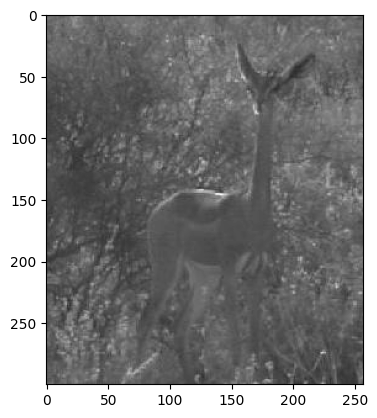

In [50]:
plt.imshow(results.iloc[1]["im"], cmap="gray", vmin=0, vmax=255)

<BarContainer object of 300 artists>

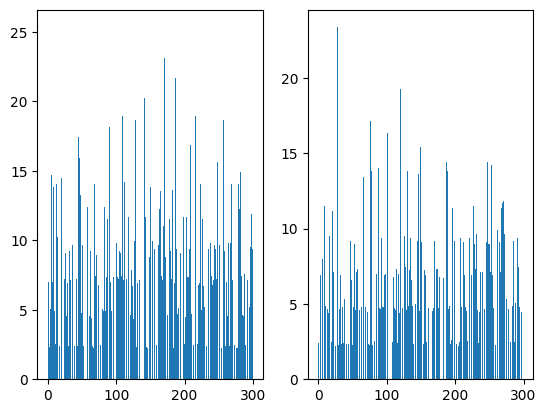

In [29]:
# clusters length
'''
    Filler code for testing
'''
images = os.listdir("caltech-101/101_ObjectCategories/hawksbill/")
train, test = train_test_split(images, test_size=0.5, random_state=42)
examples = [cv2.imread(os.path.join("caltech-101/101_ObjectCategories/hawksbill/", file)) for file in train]
features = extract_features(examples)
clusters = cluster_features(features, k=300)

#plot histograms
plt.subplot(1, 2, 1)
plt.bar(np.arange(0, len(clusters)), results.iloc[0]["hist"])
plt.subplot(1, 2, 2)
plt.bar(np.arange(0, len(clusters)), results.iloc[1]["hist"])

# Experiments

In [33]:
def experiment_train():
    mrr_train = 0
    top3_train = 0

    for i, row in results.iterrows():
        if row["train-test"] == "train":
            rank_pos = results[results['train-test'] == 'train'].index.get_loc(i) + 1
            mrr_train += 1/rank_pos

    mrr_train /= len(results[results['train-test'] == 'train'])
    print(mrr_train)

experiment_train()

[0.93719879 0.94719879 0.92386546 0.93053212 0.92386546 0.92386546
 0.93053212 0.94719879 0.93719879 0.93719879 0.93719879 0.93719879
 0.92386546 0.93053212 0.93719879 0.92386546 0.92386546 0.94719879
 0.94719879 0.92386546 0.93053212 0.93053212 0.93053212 0.94719879
 0.93053212 0.93719879 0.93053212 0.94719879 0.93719879 0.93719879
 0.92386546 0.93719879 0.92386546 0.92386546 0.93719879 0.93719879
 0.93719879 0.92386546 0.94719879 0.94719879 0.93719879 0.93719879
 0.93053212 0.93719879 0.94719879 0.92386546 0.93719879 0.92386546
 0.93053212 0.92386546 0.93719879 0.92386546 0.93719879 0.92386546
 0.93719879 0.95386546 0.93053212 0.93053212 0.94719879 0.92386546
 0.94719879 0.92386546 0.93719879 0.95386546 0.93719879 0.92386546
 0.93053212 0.93719879 0.92386546 0.94719879 0.93719879 0.92386546
 0.93053212 0.93053212 0.92386546 0.92386546 0.93719879 0.92386546
 0.92386546 0.94719879 0.93719879 0.93053212 0.92386546 0.94719879
 0.93719879 0.94719879 0.93719879 0.93053212 0.95386546 0.9371